In [1]:
%load_ext autoreload
%autoreload 2

import ccxt
import time

In [2]:
# mlflowの設定
import mlflow

mlflow.set_tracking_uri('http://mlflow:8890')
mlflow.set_experiment('crypto_portfolio_bot')

# 実験のパラメータ
experiment_options = {
    'risk_target': 0.5,
    'download_timebar': True,
    'calculate_topx': False,
    'l2_reg': True,
    'abs_limit': True,
    'weight_upper_bound': 1,
    'weight_lower_bound': -1,
    'rebalance_interval': 2*60*60, # ポートフォリオリバランス間隔 [秒]
    'execution_period': 1.5*60*60, # ポートフォリオリバランス実行期間 [秒]
    'timebar_interval': 5*60,
    'weight_calc_period': 30*24*60*60,  # ポートフォリオ計算時のリターン系列の長さ [秒]
}

mlflow.end_run()
mlflow.log_dict(experiment_options, 'experiment_optios.json')

for _idx, _value in enumerate(experiment_options):
    print(f'{_value} {experiment_options[_value]}')
    mlflow.log_param(_value, experiment_options[_value])

risk_target 0.5
download_timebar True
calculate_topx False
l2_reg True
abs_limit True
weight_upper_bound 1
weight_lower_bound -1
rebalance_interval 7200
execution_period 5400.0
timebar_interval 300
weight_calc_period 2592000


In [3]:
# 時間足データを保存する時に使うTimescaleDB用のユーティリティライブラリの設定

import os
from timescaledb_util import *

pg_config = {
    'user': os.environ['POSTGRES_USER'],
    'password': os.environ['POSTGRES_PASSWORD'],
    'host': os.environ['POSTGRES_HOST'],
    'port': os.environ['POSTGRES_PORT'],
    'database': os.environ['POSTGRES_DATABASE_OHLCV_TRADES']
}

# TimescaleDBアクセス用のユーティリティオブジェクトを作成
dbutil = TimeScaleDBUtil(user = pg_config['user'], password = pg_config['password'], host = pg_config['host'], port = pg_config['port'], database = pg_config['database'])

In [4]:
from decimal import Decimal
from datetime import timezone, datetime, timedelta
import numpy as np
import pandas as pd
from tqdm import tqdm

pd.set_option("display.max_rows", 50)
pd.set_option("display.min_rows", 50)
idxslice = pd.IndexSlice

# タイムバーをダウンロードしてTimescaleDBに保存する関数、所定のdict型の配列でダウンロード対象を指定する
def download_timebar(targets):
    for target in targets:
        _exchange = target['exchange']
        _ccxt_client = getattr(ccxt, _exchange)()
        _ccxt_client.load_markets()

        _symbol = target['symbol']
        _interval = target['interval']
        
        since = int(time.mktime(datetime.strptime('2019-01-01 00:00:00+0000', '%Y-%m-%d %H:%M:%S%z').timetuple()) * 1000)

        dbutil.init_timebar_table(_exchange, _symbol, _interval)
        table_name = dbutil.get_timebar_table_name(_exchange, _symbol, _interval)

        df = dbutil.get_latest_timebar(_exchange, _symbol, _interval)
        if type(df) != type(None):
            latest_datetime = df['datetime']
            latest_timestamp = int(latest_datetime.timestamp() * 1000) + 1

            if latest_timestamp > since:
                since = latest_timestamp

        till = int(datetime.now(tz = timezone.utc).timestamp() * 1000)
        origin = since

        with tqdm(total = int(till - origin), initial=0) as _pbar:
            _pbar.set_postfix_str(f'{_exchange}, {_symbol}, {_interval}, row_counts: 0')
            while since <= till:
                time.sleep(ccxt_client.rateLimit / 1000)

                result = ccxt_client.fetch_ohlcv(_symbol, _interval, since = int(since), limit = 1000) # 5min

                df = pd.DataFrame.from_dict(result, dtype=str)
                if len(df) == 0:
                    break

                _to_decimal = lambda x: Decimal(x)

                df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']
                df['datetime'] = df['datetime'].apply(lambda x: datetime.fromtimestamp(float(x) / 1000, tz = timezone.utc))
                df['datetime_from'] = df['datetime'] - timedelta(seconds=300) - timedelta(microseconds=1)
                df['open'] = df['open'].apply(_to_decimal)
                df['high'] = df['high'].apply(_to_decimal)
                df['low'] = df['low'].apply(_to_decimal)
                df['close'] = df['close'].apply(_to_decimal)
                df['volume'] = df['volume'].apply(_to_decimal)

                nan_columns = ['id', 'id_from', 'dollar_volume', 'dollar_buy_volume', 'dollar_sell_volume', 'dollar_liquidation_volume', 'dollar_liquidation_buy_volume', 'dollar_liquidation_sell_volume', 'dollar_cumsum', 'dollar_buy_cumsum', 'dollar_sell_cumsum']
                for column in nan_columns:
                    df[column] = Decimal(0)

                ret = dbutil.df_to_sql(df=df, schema = table_name, if_exists = 'append')

                since = int(df.iloc[-1]['datetime'].timestamp()*1000) + 1
                _pbar.n = since - origin
                _pbar.set_postfix_str(f'{_exchange}, {_symbol}, {_interval}, row_counts: {len(df)}')
                _pbar.refresh()

In [5]:
# CCXTのクライアントを作り、無期限先物市場の5分足情報をTimescaleDBに書き込む

if experiment_options['download_timebar'] == True:
    # USDT建ての無期限先物を時間足ダウンロードの対象として設定する
    ccxt_client = getattr(ccxt, 'binanceusdm')()
    ccxt_client.load_markets()

    targets = []
    for symbol in ccxt_client.symbols:
        if '/USDT' in symbol:
            target_5m = {
                'exchange': 'binanceusdm',
                'symbol': symbol,
                'interval': f'{experiment_options["timebar_interval"]/60:.0f}m'
            }
            targets.append(target_5m)

    # USDT建ての無期限先物の5分足をTimescaleDBにダウンロードする
    download_timebar(targets)

 72%|███████▏  | 300000/418129 [00:00<00:00, 913359.25it/s, binanceusdm, ZRX/USDT, 5m, row_counts: 1] 


In [6]:
# ダウンロードした無期限先物の直近50000本分の取引ボリュームを概算する

if experiment_options['calculate_topx'] == True:
    result = []
    row_counts = 0

    with tqdm(total = len(targets), initial=0) as _pbar:
        for target in targets:
            _exchange = target['exchange']
            _symbol = target['symbol']
            _interval = target['interval']

            table_name = dbutil.get_timebar_table_name(_exchange, _symbol, _interval)
            df = dbutil.read_sql_query(f'SELECT open, close, volume from "{table_name}"')
            recent_dollar_volume = (df.iloc[-50000:]['volume'] * (df.iloc[-50000:]['close'] + df.iloc[-50000:]['open']) / 2).sum()
            result.append({'symbol': _symbol, 'rows': len(df), 'recent_dollar_volume': recent_dollar_volume})

            row_counts = row_counts + len(df)
            _pbar.n = _pbar.n + 1
            _pbar.set_postfix_str(f'{_symbol}, row_counts: {row_counts:,}, recent_dollar_volume: {recent_dollar_volume:,}')
            _pbar.refresh()

    df_recent_volume = pd.DataFrame(result)
    
    # 取引ボリューム概算結果を表示する
    df_recent_volume = df_recent_volume.sort_values('recent_dollar_volume', ascending=False)
    df_recent_volume['listed_days'] = df_recent_volume['rows']*5/60/24
    df_recent_volume = df_recent_volume.reset_index(drop=True)
    display(df_recent_volume[df_recent_volume['listed_days'] > 250])
    
    # 取引ボリューム概算が大きい順に10銘柄でポートフォリオの挙動をテストする
    portfolio_symbols = df_recent_volume[df_recent_volume['listed_days'] > 250].iloc[:10]['symbol']
else:
    portfolio_symbols = ['BTC/USDT', 'ETH/USDT', '1000SHIB/USDT', 'SOL/USDT', 'SAND/USDT', 'LUNA/USDT', 'FTM/USDT', 'XRP/USDT', 'ADA/USDT', 'AVAX/USDT']

print(f'Target symbols are {portfolio_symbols}')

Target symbols are ['BTC/USDT', 'ETH/USDT', '1000SHIB/USDT', 'SOL/USDT', 'SAND/USDT', 'LUNA/USDT', 'FTM/USDT', 'XRP/USDT', 'ADA/USDT', 'AVAX/USDT']


In [7]:
import talib

# ポートフォリオ構成銘柄の価格系列などを準備する
dfs = []
for _symbol in tqdm(portfolio_symbols):
    _table_name = dbutil.get_timebar_table_name('binanceusdm', _symbol, '5m')
    _df = dbutil.read_sql_query(f'SELECT datetime, close from "{_table_name}" WHERE datetime < \'2022-02-21 00:00:00+00\' AND datetime >= \'2021-01-01 00:00:00+00\' ORDER BY datetime ASC', index_column = '')
    _df.loc[:, 'symbol'] = _symbol
    _df.loc[:, 'ret'] = _df.loc[:, 'close'].pct_change()
    _df.loc[:, 'twap'] = talib.SMA(_df.loc[:, 'close'], timeperiod = int(experiment_options['execution_period'] / experiment_options['timebar_interval'])).shift()
    _df.dropna(inplace = True)
    dfs.append(_df)

df_portfolio = pd.concat(dfs).set_index(['datetime', 'symbol']).sort_index()

# ウェイトを入れる列を準備する
df_portfolio['w'] = np.nan
_row_index = df_portfolio.iloc[0].name
df_portfolio.loc[idxslice[_row_index, :], 'w'] = 0.0

100%|██████████| 10/10 [00:08<00:00,  1.25it/s]
/tmp/ipykernel_675340/3531717180.py:19: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  df_portfolio.loc[idxslice[_row_index, :], 'w'] = 0.0


In [8]:
# PyPortfolioOptを利用してポートフォリオウェイトを計算

from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions
from pypfopt import plotting

import cvxpy as cp

COV_LENGTH = int(experiment_options['weight_calc_period'] / experiment_options['timebar_interval'])

df_weight_calc = df_portfolio.reset_index().pivot(index = 'datetime', columns = 'symbol', values='close')
array_performance = []

for i in tqdm(range(df_weight_calc.shape[0])):
    # リバランスの時間でだけポートフォリオのウェイトを計算する
    if df_weight_calc.index[i].timestamp() % experiment_options['rebalance_interval'] == 0:
        # 十分なリターン系列の長さがない場合は精度が出ないのでウェイト計算を行わない
        if i + 1 < COV_LENGTH:
            continue
        _df_cov = df_weight_calc.iloc[max(0, i - COV_LENGTH + 1):i + 1].dropna(axis=1)
        
        # 構成銘柄が1銘柄しかない場合にはウェイト計算を行わない
        if _df_cov.shape[1] <= 1:
            continue
            
        # ここよりPyPortfolioOptによるポートフォリオウェイト計算
        _mu = mean_historical_return(_df_cov)
        _S = CovarianceShrinkage(_df_cov).ledoit_wolf()
        _ef = EfficientFrontier(_mu, _S, weight_bounds = (experiment_options['weight_lower_bound'], experiment_options['weight_upper_bound']))
        if experiment_options['l2_reg'] == True:
            _ef.add_objective(objective_functions.L2_reg, gamma=0.1) # L2正則化を入れてひとつの銘柄にウェイトが集中するのを防ぐ
        if experiment_options['abs_limit'] == True:
            _ef.add_constraint(lambda w: cp.sum(cp.abs(w)) <= 1) # ポジションの絶対値の合計を制限する
        
        # ボラティリティの目標値を0.25に設定し、その中で最大のリターンをもたらすウェイトを計算する
        _weights = _ef.efficient_risk(experiment_options['risk_target'])
        _cleaned_weights = _ef.clean_weights()
        _return, _volatility, _sharpe = _ef.portfolio_performance()
        array_performance.append([df_weight_calc.index[i], _return, _volatility, _sharpe])
        
        for _key, _value in _cleaned_weights.items():
            df_portfolio.loc[(df_weight_calc.index[i], _key), 'w'] = _value

100%|██████████| 119790/119790 [05:01<00:00, 397.96it/s]


In [9]:
df_portfolio_performance = pd.DataFrame(array_performance, columns=['datetime', 'return', 'volatility', 'sharpe']).set_index('datetime', drop = True)

close       ret          twap  \
datetime                  symbol                                                
2021-01-01 01:30:00+00:00 ADA/USDT           0.182650  0.003020      0.180369   
                          AVAX/USDT          3.162000 -0.006160      3.192883   
                          BTC/USDT       29402.130000 -0.001198  29041.456111   
                          ETH/USDT         742.990000 -0.000565    736.085556   
                          FTM/USDT           0.017287  0.001680      0.016990   
                          SOL/USDT           1.594300  0.002326      1.528400   
                          XRP/USDT           0.224500 -0.004435      0.221400   
2021-01-01 01:35:00+00:00 ADA/USDT           0.183530  0.004818      0.180477   
                          AVAX/USDT          3.178000  0.005060      3.193256   
                          BTC/USDT       29441.540000  0.001340  29063.796667   
                          ETH/USDT         748.030000  0.006783    736.385000   
                          FTM/USDT           0.017306  0.001099      0.017007   
                          SOL/USDT           1.593300 -0.000627      1.533061   
                          XRP/USDT           0.224300 -0.000891      0.221628   
2021-01-01 01:40:00+00:00 ADA/USDT           0.184650  0.006103      0.180704   
...                                               ...       ...           ...   
2022-02-20 23:50:00+00:00 FTM/USDT           1.721900 -0.003242      1.736356   
                          LUNA/USDT         49.284000 -0.001924     49.640222   
                          SAND/USDT          3.188800 -0.002814      3.223750   
                          SOL/USDT          90.460000 -0.002756     91.941667   
                          XRP/USDT           0.774500 -0.001933      0.781550   
2022-02-20 23:55:00+00:00 1000SHIB/USDT      0.025467  0.002164      0.025578   
                          ADA/USDT           0.930800  0.002153      0.941239   
                          AVAX/USDT         77.270000  0.002855     77.814444   
                          BTC/USDT       38368.100000 -0.000047  38540.494444   
                          ETH/USDT        2620.720000 -0.000484   2634.321667   
                          FTM/USDT           1.723800  0.001103      1.736378   
                          LUNA/USDT         49.299000  0.000304     49.635278   
                          SAND/USDT          3.194800  0.001882      3.224117   
                          SOL/USDT          90.630000  0.001879     91.885556   
                          XRP/USDT           0.776400  0.002453      0.781517   

                                           w  
datetime                  symbol              
2021-01-01 01:30:00+00:00 ADA/USDT       0.0  
                          AVAX/USDT      0.0  
                          BTC/USDT       0.0  
                          ETH/USDT       0.0  
                          FTM/USDT       0.0  
                          SOL/USDT       0.0  
                          XRP/USDT       0.0  
2021-01-01 01:35:00+00:00 ADA/USDT       NaN  
                          AVAX/USDT      NaN  
                          BTC/USDT       NaN  
                          ETH/USDT       NaN  
                          FTM/USDT       NaN  
                          SOL/USDT       NaN  
                          XRP/USDT       NaN  
2021-01-01 01:40:00+00:00 ADA/USDT       NaN  
...                                      ...  
2022-02-20 23:50:00+00:00 FTM/USDT       NaN  
                          LUNA/USDT      NaN  
                          SAND/USDT      NaN  
                          SOL/USDT       NaN  
                          XRP/USDT       NaN  
2022-02-20 23:55:00+00:00 1000SHIB/USDT  NaN  
                          ADA/USDT       NaN  
                          AVAX/USDT      NaN  
                          BTC/USDT       NaN  
                          ETH/USDT       NaN  
                          FTM/USDT       NaN  
           

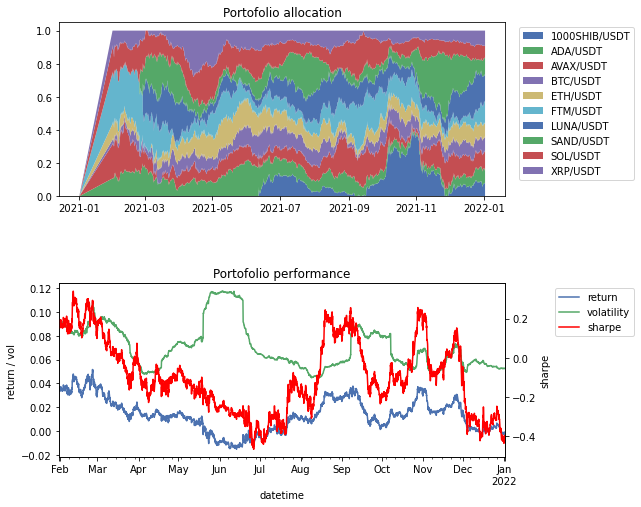

In [24]:
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 30)
pd.set_option("display.min_rows", 30)
display(df_portfolio)
pd.reset_option("display.max_rows")
pd.reset_option("display.min_rows")


# 行のすべてのウェイトが0またはNaNの行を削除してウェイト用のDataFrameを完成させる
df_weight = df_portfolio.reset_index().pivot(index = 'datetime', columns = 'symbol', values='w').dropna(how = 'all').fillna(0)

fig, ax = plt.subplots(2, 1, figsize=(8, 8))
plt.subplots_adjust(wspace=0.2, hspace=0.5)
    
ax[0].stackplot(df_weight['2021-01-01':'2022-01-01'].index, df_weight['2021-01-01':'2022-01-01'].T, labels=df_weight.columns)
ax[0].legend(bbox_to_anchor=(1.3, 1))
ax[0].set_title(f'Portofolio allocation')

lines = []

df_portfolio_performance['2021-01-01':'2022-01-01']['return'].plot(ax = ax[1], label='return')
df_portfolio_performance['2021-01-01':'2022-01-01']['volatility'].plot(ax = ax[1], label='volatility')
ax_sub = ax[1].twinx()
ax_sub.set_ylabel('sharpe')
df_portfolio_performance['2021-01-01':'2022-01-01']['sharpe'].plot(ax = ax_sub, style='r-', label='sharpe')
ax[1].set_title(f'Portofolio performance')
ax[1].set_ylabel('return / vol')
handle, label = ax[1].get_legend_handles_labels()
handle2, label2 = ax_sub.get_legend_handles_labels()

ax[1].legend(handle + handle2, label + label2, bbox_to_anchor=(1.3, 1))


fig.show()
#mlflow.log_figure(fig, 'portofolio_weight.png')

In [11]:
mlflow.end_run()